In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

Loss: 22.070964813232422
Loss: 19.234045028686523
Loss: 20.122018814086914
Loss: 18.00627899169922
Loss: 16.886409759521484
Loss: 19.805500030517578
Loss: 17.604923248291016
Loss: 19.73303985595703
Loss: 17.278608322143555
Loss: 16.535181045532227
Loss: 17.857746124267578
Loss: 14.446293830871582
Loss: 16.863317489624023
Loss: 13.31159782409668
Loss: 17.117820739746094
Loss: 15.324713706970215
Loss: 11.193740844726562
Loss: 15.92508316040039
Loss: 15.28561782836914
Loss: 17.22372055053711
Loss: 16.26638412475586
Loss: 14.608067512512207
Loss: 14.999452590942383
Loss: 13.379640579223633
Loss: 12.703950881958008
Loss: 13.295614242553711
Loss: 13.729684829711914
Loss: 13.279504776000977
Loss: 11.4437894821167
Loss: 11.727728843688965
Loss: 11.211515426635742
Loss: 3.275825262069702
Loss: 11.244701385498047
Loss: 10.072379112243652
Loss: 11.030529022216797
Loss: 11.437873840332031
Loss: 10.369898796081543
Loss: 13.424948692321777
Loss: 11.251501083374023
Loss: 14.48365592956543
Loss: 10.37

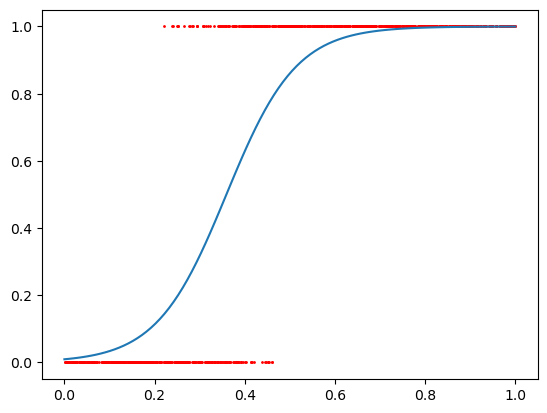

In [42]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)


#Helper variables/functions
alpha = 0.05 #learning rate

def log_likelihood(y, p, K):
  sum = 0
  for i in range(K):
    summand = y * torch.log(p) + (1 - y)*torch.log(1 - p)
    sum += summand
  return sum

for epoch in range(15):
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    p_x = 1 / (1 + torch.exp(-(b1 + b2*x)))

    # Calculate the negative loss likelihood
    nll = -torch.sum(y * torch.log(p_x) + (1 - y) * torch.log(1 - p_x))

    # Calculate the gradient of the loss w.r.t. the inputs
    partial_b1 = -torch.sum(y - p_x)
    partial_b2 = -torch.sum(x * (y - p_x))

    # Update the parameters b according to SGD formula
    b1 = b1 - alpha * partial_b1
    b2 = b2 - alpha * partial_b2

    # Print out the loss value
    print(f"Loss: {nll.item()}")

# Reproduce the image above to validate your result.
xs = torch.linspace(0, 1, 100)
ys = 1 / (1 + torch.exp(-(b1 + b2*xs)))
plt.plot(xs.detach().numpy(), ys.detach().numpy())

plt.scatter(input.numpy(), label.numpy(), s = 1, c = "r")


